In [3]:
import requests
import pandas as pd
import numpy as np 
from pyarrow import fs
import pyarrow as pa
import pyarrow.parquet as pq
from scipy.stats import zscore
import matplotlib.pyplot as plt
pd.set_option('display.float_format', '{:.2f}'.format)
s3=connect_s3("aayrapetyan")

In [235]:
def get_names_geo_data_from_sncf_api(endpoint_suffix, **kwargs):
    base_url = "https://ressources.data.sncf.com"
    # Endpoint for the desired dataset
    endpoint = f"/api/explore/v2.1/catalog/datasets/{endpoint_suffix}/records"
    # Parameters for the API request
    params = {
        "limit": 100,  # in this API maximum limit is 100
        "offset": 0,  # we start from 0 to 100, then FROM 100 to 200 etc etc, but limit is fixed at 100, it is moving
    }
    params.update(kwargs)
    # Construct the full URL
    url = f"{base_url}{endpoint}"
    response = requests.get(url, params=params)
    wb = response.json()
    resulting_dictionnary = wb["results"].copy()
    while wb["results"] != []:
        params["offset"] = params["offset"] + 100
        response = requests.get(url, params=params)
        if response.status_code == 200:
            wb = response.json()
            for element in wb["results"]:
                resulting_dictionnary.append(element)
    # verify nb of observations
    print(
        f"nb of stations downloaded: {len(resulting_dictionnary)}, from table {endpoint_suffix}"
    )
    # df = pd.json_normalize(resulting_dictionnary)
    return resulting_dictionnary


def get_absent_lat_lon_from_gouv_api(df):
    empties = df[df["lon"].isna()].copy()
    base_url = "https://api-adresse.data.gouv.fr/search/"
    # Paramètres de la requête
    params = {"q": "", "limit": 1}
    i = 0
    for idx, row in empties.iterrows():
        params["q"] = "gare de " + row["nom_gare"]
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            data = response.json()
            coordinates = data["features"][0]["geometry"]["coordinates"]
            i = i + 1
        else:
            coordinates = [None, None]
        df.loc[idx, "lon"] = coordinates[0]
        df.loc[idx, "lat"] = coordinates[1]
    print(i, "absent addresses filled successfully")
    return df


def delete_outliers_z_score(df, series):
    df["z_score"] = zscore(series)
    no_outliers_table = df[df["z_score"].abs() < 3]

    print("nb removed observations : ", df.shape[0] - no_outliers_table.shape[0])
    no_outliers_table = no_outliers_table.drop("z_score", axis=1)
    return no_outliers_table


def plot_hist(series, title_suffix=""):

    plt.figure(figsize=(3, 2))
    plt.hist(series, bins=50, edgecolor="black")
    plt.title(f"Histogram of {series.name} {title_suffix}", fontsize=14)
    plt.xlabel(series.name, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis="y", linestyle="--")
    plt.show()


def simple_plot_map():
    plt.scatter(merged["lon"], merged["lat"], s=1, color="black")
    plt.title("Stations in France")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


def from_json_to_parquet_store_in_s3(json_table, directory):
    table = pa.Table.from_pylist(json_table)
    pq.write_table(table, directory, filesystem=s3)

def from_pandas_to_parquet_store_in_s3(df, directory):
    table = pa.Table.from_pandas(df)
    pq.write_table(table, directory, filesystem=s3)



# connect and verify
def connect_s3(directory):
    try:
        s3 = fs.S3FileSystem(endpoint_override="https://" + "minio.lab.sspcloud.fr")
        s3.get_file_info(fs.FileSelector(directory, recursive=True))
    except:
        print("connection not established, debug ")
    return s3


def get_tables_from_s3(directory):
    df = pq.ParquetDataset(directory, filesystem=s3).read_pandas().to_pandas()
    return df

 extract tables from api

In [48]:
station_geo_data = get_names_geo_data_from_sncf_api(
    endpoint_suffix="gares-de-voyageurs",
    select="""nom as nom_gare,
                           position_geographique,
                           codeinsee,
                           codes_uic as uic""",
)

station_freq_data = get_names_geo_data_from_sncf_api(
    endpoint_suffix="frequentation-gares",
    select="""total_voyageurs_2022,
                           code_postal,
                           nom_gare,
                           code_uic_complet as uic """,
)

nb of stations downloaded: 2881, from table gares-de-voyageurs
nb of stations downloaded: 3010, from table frequentation-gares


connect to s3, store tables from api to s3

In [49]:
s3=connect_s3("aayrapetyan")
from_json_to_parquet_store_in_s3(station_geo_data,"aayrapetyan/station_geo_data.parquet")
from_json_to_parquet_store_in_s3(station_freq_data,"aayrapetyan/station_freq_data.parquet")

extract tables from s3

In [4]:
station_geo_data=get_tables_from_s3("aayrapetyan/station_geo_data.parquet")
station_freq_data=get_tables_from_s3("aayrapetyan/station_freq_data.parquet")

data cleaning and prep

In [5]:
station_geo_data['lat'] = station_geo_data['position_geographique'].apply(
    lambda x: x['lat'] if x is not None else None
)
station_geo_data['lon'] = station_geo_data['position_geographique'].apply(
    lambda x: x['lon'] if x is not None else None
)


In [6]:
station_geo_data=station_geo_data.drop("position_geographique",axis=1)

In [7]:
merged=station_freq_data.merge(station_geo_data.drop("nom_gare",axis=1),on=["uic"],how="left")
merged=merged[merged["total_voyageurs_2022"]>0]


In [8]:
merged=get_absent_lat_lon_from_gouv_api(merged)
merged.isna().sum()

94 absent addresses filled successfully


total_voyageurs_2022     0
code_postal              0
nom_gare                 0
uic                      0
codeinsee               94
lat                      0
lon                      0
dtype: int64

In [148]:

merged.loc[:, "code_postal_department"] = merged["code_postal"].str[0:2]

get stat about regions

In [211]:
regional_stat=get_tables_from_s3("clichere/diffusion/rev_dip_pop_comm.parquet")

In [212]:
regional_stat.loc[:, "code_postal_department"] = regional_stat["codecommune"].str[0:2]

In [213]:
regional_stat=regional_stat[(regional_stat["pop2022"]>0) & (regional_stat["revmoy2022"]>0) & (regional_stat["pbac2022"].notna())   ]

In [224]:
regional_stat

,codecommune,nomcommune,pop2022,revmoy2022,pbac2022,psup2022,code_postal_department
0,01001,ABERGEMENT-CLEMENCIAT,747,21615.65,0.45,0.23,01
1,01002,ABERGEMENT-DE-VAREY,288,16945.77,0.67,0.09,01
2,01004,AMBERIEU-EN-BUGEY,14375,18423.11,0.46,0.29,01
3,01005,AMBERIEUX-EN-DOMBES,1717,20996.12,0.34,0.17,01
4,01006,AMBLEON,116,18075.99,1.00,0.01,01
...,...,...,...,...,...,...,...
36627,95676,VILLERS-EN-ARTHIES,529,20655.25,0.53,0.51,95
36628,95678,VILLIERS-ADAM,927,26113.93,0.89,0.67,95
36629,95680,VILLIERS-LE-BEL,27033,11837.68,0.44,0.23,95
36630,95682,VILLIERS-LE-SEC,248,18516.31,0.27,0.09,95


In [228]:
base_url = "https://api-adresse.data.gouv.fr/search/"
# Paramètres de la requête
params = {"q": "01003 FR", "limit": 1}
response = requests.get(base_url, params=params)
data = response.json()
coordinates = data["features"][0]["geometry"]["coordinates"]
coordinates

IndexError: list index out of range

In [230]:


base_url = "https://api-adresse.data.gouv.fr/search/"
# Paramètres de la requête
params = {"q": "", "limit": 1}
i = 0
for idx, row in regional_stat.iterrows():
   if i%100==0:
    print(i)
   params["q"] = f"{row["nomcommune"]} {row["codecommune"]}"
   response = requests.get(base_url, params=params)
   try :
       data = response.json()
       coordinates = data["features"][0]["geometry"]["coordinates"]
       i = i + 1
   except:
       coordinates = [None, None]
   regional_stat.loc[idx, "lon"] = coordinates[0]
   regional_stat.loc[idx, "lat"] = coordinates[1]



0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [236]:
from_pandas_to_parquet_store_in_s3(regional_stat,"aayrapetyan/station_geo_data.parquet")

In [216]:
fusion=merged.merge(regional_stat.drop('code_postal_department',axis=1),left_on="code_postal",right_on="codecommune",how="left")

In [217]:
lack=fusion[fusion["codecommune"].isna()]

# visuqlisations

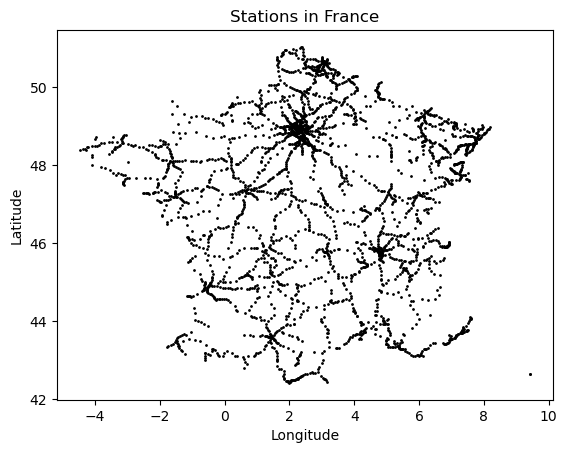

In [46]:
simple_plot_map()

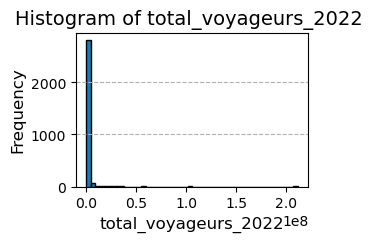

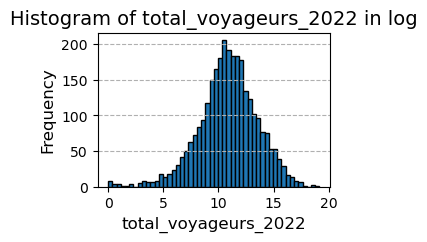

nb removed observations :  24


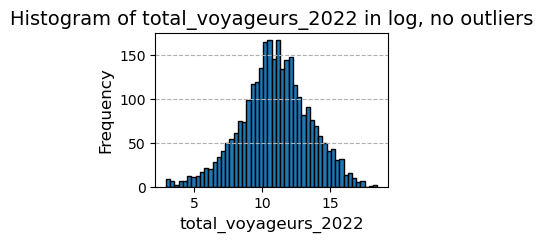

In [106]:
plot_hist(series=(merged['total_voyageurs_2022']))
plot_hist(series=np.log(merged['total_voyageurs_2022']),title_suffix="in log")
no_outliers_table=delete_outliers_z_score(merged,np.log(merged["total_voyageurs_2022"]))
plot_hist(np.log(no_outliers_table['total_voyageurs_2022']),title_suffix="in log, no outliers")


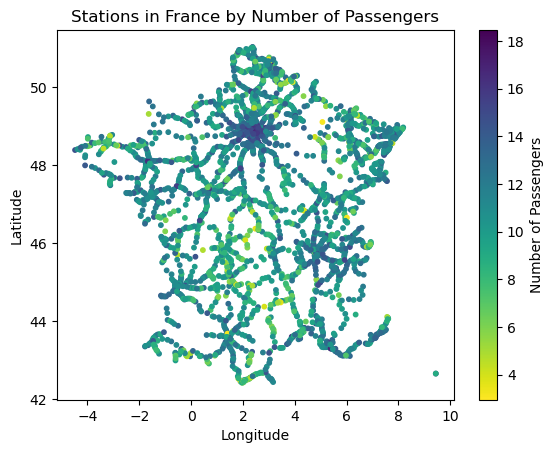

In [ ]:

plt.scatter(
    no_outliers_table['lon'], 
    no_outliers_table['lat'], 
    s=10,  # Increase size for visibility
    c=np.log(no_outliers_table['total_voyageurs_2022']),  # Color based on number of passengers
    cmap='viridis_r'  # Use a perceptible color map
)
plt.colorbar(label='Number of Passengers')  # Add color legend
plt.title("Stations in France by Number of Passengers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
#idea about difference in france among regions but... size effect because of population disperancy, so we have to take population info too to adjust for it 

In [107]:
no_outliers_table

,total_voyageurs_2022,code_postal,nom_gare,uic,codeinsee,lon,lat
0,40825,44170,Abbaretz,87481614,44001,-1.52,47.55
1,177092,78100,Achères Grand Cormier,87386052,78551,2.09,48.96
2,80648,62121,Achiet-le-Grand,87342048,62005,2.78,50.13
3,32800,83530,Agay,87757559,83118,6.86,43.43
4,11325,30220,Aigues-Mortes,87775858,30003,4.19,43.57
...,...,...,...,...,...,...,...
3004,176599,67720,Weyersheim,87213678,67529,7.80,48.72
3005,30849,68760,Willer-sur-Thur,87182584,68372,7.07,47.84
3006,37020,62126,Wimille - Wimereux,87317123,62894,1.61,50.76
3007,38618,40100,Ygos-Saint-Saturnin,87671487,40333,-0.74,43.98


In [ ]:
# import folium
# import requests


# geojson_url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson"
# geojson_data = requests.get(geojson_url).json()
# #Create a base map centered on France
# france_map = folium.Map(location=[46.603354, 1.888334], zoom_start=6)
# #SON layer to the map with style
# folium.GeoJson(
#     geojson_data,
#     name="Departments",
#     style_function=lambda x: {
#         'fillColor': '#ff7800',  # Use distinct colors or randomization for better visibility
#         'color': 'black',
#         'weight': 1,
#         'fillOpacity': 0.5
#     },
#     tooltip=folium.GeoJsonTooltip(fields=["nom"], aliases=["Department"])  # Tooltip to show department name
# ).add_to(france_map)
# folium.LayerControl().add_to(france_map)


